<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

# AST4310 2024, Project 1


</div>

Authored by: 11 and 6.

In [67]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy.visualization import quantity_support
from astropy import units, constants
from scipy.integrate import cumulative_trapezoid
from atoms import Atom 
from read_nist import read_NIST_species

# Plot defaults and quantity supportS
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x1d2b9d48460>

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Exercise 1: Line formation in optically thick medium [30 points]
    
Assume an optically thick medium, where the Eddington-Barbier approximation is valid. A didactic tool to understand the formation of spectral lines is a diagram with four panels: total extinction vs. frequency (top left), optical depth vs height (top right), source function vs. height (bottom right), and emerging intensity vs. frequency (bottom left). It is also useful to plot the optical depth at two frequency points: near the maximum extinction and near the minimum extinction. 
    
In this exercise, you are to create such diagrams and explain in physical terms what is going on. The units are not important for these purposes, so feel free to use arbitrary units. You are free to create your own function for $\alpha(\nu)$ (extinction as a function of frequency), but keep in mind that spectral lines usually follow a Gaussian shape (or, more precisely, Voigt profile), and continua can usually be approximated by a line (for narrow wavelength regions). You are also free to select your own function for $S(h)$ (source function as a function of height). It is recommended that you do not set the extinction such that $\tau=1$ is reached at the edges of your height scale - some approximations will break down and strange things will follow. Assume that the extinction is the same at all height points (unrealistic, but simple for now).
    
* *[10 points]* Build $\alpha(\nu)$ and $S(h)$ such that the emergent intensity looks approximately like the plot below. Plot the 4-panel diagram and explain in physical terms the choices you made when building the extinction and source function. Would there be more than one way to build $\alpha$ and $S$ so that the resulting intensity would be the same?


<img src="https://tiagopereira.space/ast4310/images/intensity_plot1.svg" alt="Spectrum 1" width="400"/>

* *[10 points]* Build $\alpha(\nu)$ and $S(h)$ such that the emergent intensity looks approximately like the plot below. Plot the 4-panel diagram and explain in physical terms the choices you made when building the extinction and source function. Would there be more than one way to build $\alpha$ and $S$ so that the resulting intensity would be the same?
    
<img src="https://tiagopereira.space/ast4310/images/intensity_plot2.svg" alt="Spectrum 2" width="400"/>
    
* *[10 points]* Build $\alpha(\nu)$ and $S(h)$ such that you have a spectral line in absorption. Plot a modified version of the 4-panel diagram where in the intensity plot you have both $I(\mu=1)$ and $I(\mu=0.3)$. Explain the differences between $I(\mu=1)$ and $I(\mu=0.3)$ using the information from the diagram.
    
</div>

In [3]:
def four_panel_diagram(freq, height, source_function, extinction): 
    tau = cumulative_trapezoid(extinction, -height, axis = 0, initial = 0) # compute optical depth at all heights
    intensity = np.trapz(source_function[:, np.newaxis]*np.exp(-tau), tau, axis = 0) # compute intensity at the top of the surface
    %config InLineBackend.figure_formats = ['svg']

    fig, ax = plt.subplots(2,2,figsize = (10, 7))
    ax[0, 0].plot(freq, extinction[0])
    ax[0,0].plot([freq[0]], [extinction[0, 0].value], 'bo', ms = 7)
    ax[0,0].plot([freq[50]], [extinction[0, 50].value], 'ro', ms = 7)
    ax[0,0].plot([freq[37]], [extinction[0, 37].value], 'go', ms = 7)
    ax[0,0].set_xlabel('Frequency'), ax[0,0].set_ylabel(r'Extinction [m$^{-1}$]') 
    ax[0,0].set_title('Extinction')

    ax[0,1].plot(height, tau[:, 0], 'b-')
    ax[0,1].plot(height, tau[:, 50], 'r-')
    ax[0,1].plot(height, tau[:, 37], 'g-')
    tau1_0 = np.argmin(np.abs(tau[:, 0] - 1))
    tau1_50 = np.argmin(np.abs(tau[:, 50] - 1.0))
    tau1_37 = np.argmin(np.abs(tau[:, 37] - 1.0))
    ax[0, 1].plot([height[tau1_0].value], 1, 'bo')
    ax[0, 1].plot([height[tau1_50].value], 1, 'ro')
    ax[0, 1].plot([height[tau1_37].value], 1, 'go')
    ax[0, 1].set_xlabel('Height [km]')
    ax[0,1].set_title('Optical depth')

    ax[1, 1].plot(height, source_function)
    ax[1, 1].plot(height[tau1_0], source_function[tau1_0], 'bo', ms = 7)
    ax[1, 1].plot(height[tau1_50], source_function[tau1_50], 'ro', ms = 7)
    ax[1, 1].plot(height[tau1_37], source_function[tau1_37], 'go', ms = 7)
    ax[1, 1].set_xlabel('Height [km]'); ax[1, 1].set_ylabel(r'$S_\nu$ [kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$]')
    ax[1, 1].set_title('Source function')

    ax[1, 0].plot(freq, intensity)
    ax[1, 0].plot(freq[0], intensity[0], 'bo', ms = 7)
    ax[1, 0].plot(freq[50], intensity[50], 'ro', ms = 7)
    ax[1, 0].plot(freq[37], intensity[37], 'go', ms = 7)
    ax[1, 0].set_title('Intensity')
    ax[1, 0].set_xlabel('Frequency'); ax[1, 0].set_ylabel(r'Intensity [kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$]')

    plt.tight_layout()
    plt.show()

## Central reversal intensity plot

In [4]:
## SAME SET-UP AS GROUP SESSION. PURPOSE IS HAVE SOME VALUES TO TEST THE FUNCTION

freq = np.linspace(-5, 5, 101)
extinction = (np.exp(- freq ** 2) - 0.1 * freq / 60 + 0.2) / units.m / 600

depth = np.logspace(0, 4, 200) * units.km
height = -depth + depth.max()

i_units = units.Quantity(1, "kW m-2 nm-1 sr-1") # intensity units

# build the source function
source_function1 = (- 2.5 * np.sin(depth.value / 2e3) +  2 * np.exp(depth.value / 8e3)) * i_units # source function 1, linear

# build the extinction 
extinction = np.tile(extinction, ((len(depth)), 1))

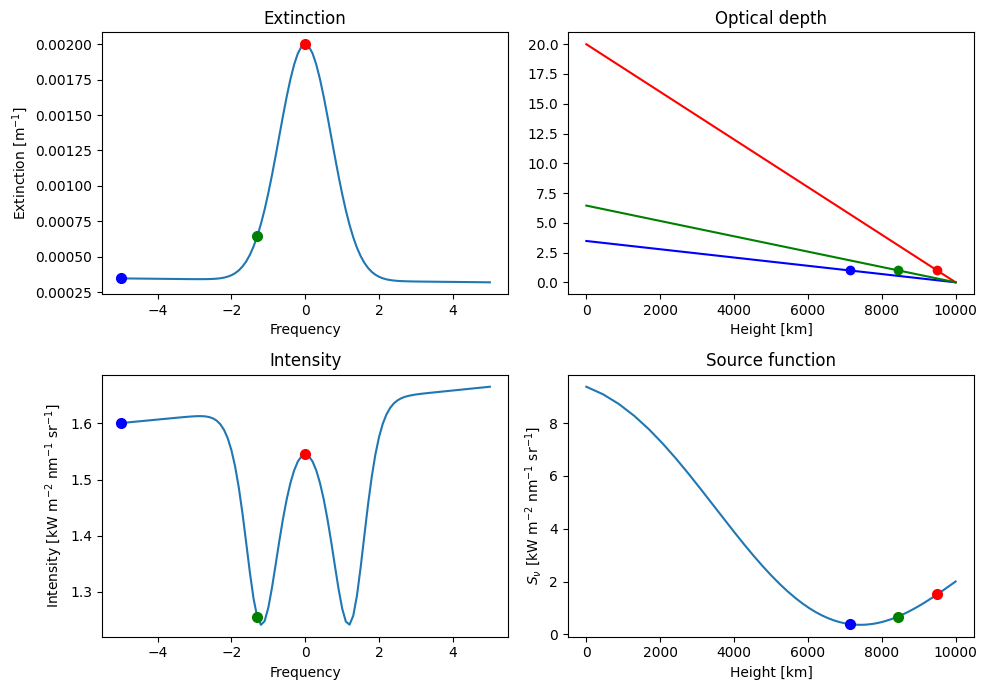

In [5]:
## ACTUALLY TESTING THE FUNCTION
four_panel_diagram(freq, height, source_function1, extinction)

## Absorption line:

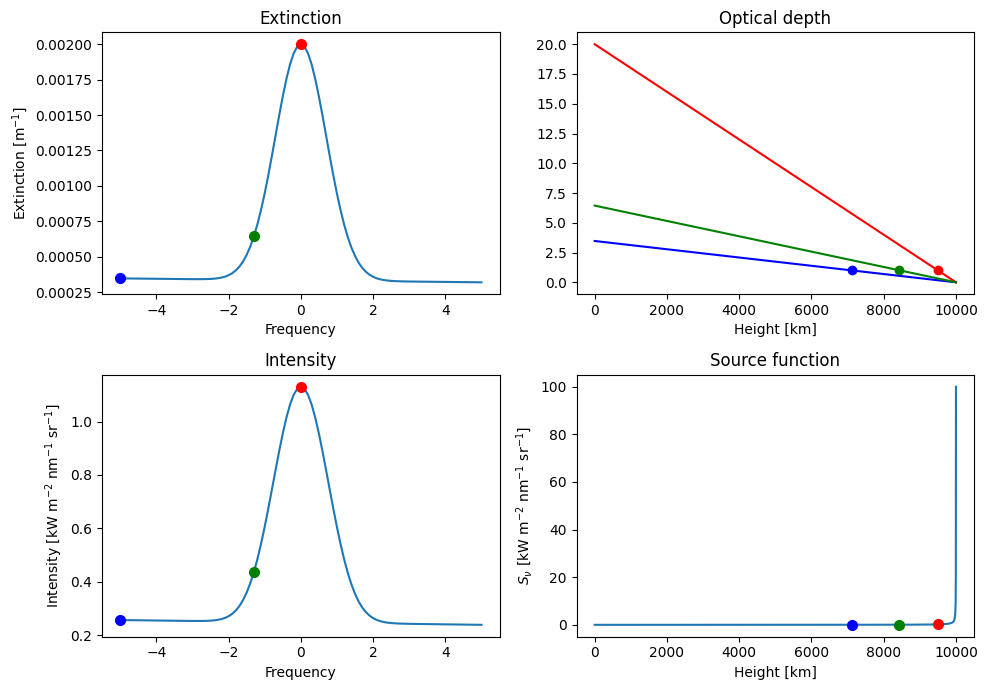

In [6]:
#extinction = (np.exp(- freq ** 2) + 0.5 * freq / 50 + 0.1) / units.m / 100

source_function2 = (depth.value) / 100 * i_units 
# build the source function
source_function = np.flip(source_function2) # source function 1, linear

four_panel_diagram(freq, height, source_function, extinction)

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Exercise 2: The Boltzmann and Saha laws [21 points]
    
An effective temperature around 9500 K is the classical divide between hot and cool stars, since it is approximately the temperature where hydrogen is 50% ionised. Hot stars have therefore mostly ionised hydrogen, and cool stars mostly neutral hydrogen.
    
* *[7 points]* Discuss what possible implications to the spectra of stars that come with hydrogen being ionised or neutral. 
* *[7 points]* Assuming that the Saha distribution can be applied, estimate what is the typical electron density in a star with effective temperature of 9500 K and a hydrogen ionisation fraction of 50%.
* *[7 points]* For the electron density you obtained before, plot the neutral fraction of hydrogen as a function of temperature.
    
</div>

## Ionized vs neutral hydrogen

Something about fewer hydrogen spectral lines for ionized hydrogen.

## Typical electron density

We assume that the Saha distribution given by
$$
\left[\frac{N_{r + 1}}{N_r}\right]^{\text{TE}}N_e = \frac{2U_{r + 1}}{U_r}\left(\frac{2\pi m_e k T}{h^2} \right)^{3/2} e^{-\chi_r / k T}
$$
can be applied. We want to estimate the typical electron density in a star with an effective temperature of 9500 K and a hydrogen ionisation fraction of 50 %.

That the hydrogen ionisation fraction is 50 % means that $N_{r + 1}/ N_{r} = 0.5$ where we let $N_{r+1}$ be the population of the first ionized stage and $N_r$ is the number of neutral atoms. We can then use the Saha distribution to find an expression for the electron density:
$$
N_e = \frac{2U_{r + 1}}{U_r}\left(\frac{2\pi m_e k T}{h^2} \right)^{3/2} e^{-\chi_r / k T} \cdot 2
$$

We use the atom class, given in `atoms.py` with temperature 9500 K as follows:

In [7]:
h_atom = Atom('H_atom.txt')

def electron_density(temperature):
    U0, U1 = h_atom.compute_partition_function(temperature) # partition function
    chi = h_atom.chi_ion[1] # ionization energy of hydrogen (might change to .chi_ion[1], but does no longer match with the formula..)
    saha_const = ((2 * np.pi * constants.m_e * constants.k_B * temperature) / (constants.h**2))**(3/2)
    N_e = (2 * U1/U0 * saha_const * np.exp(-chi / (constants.k_B*temperature)) * 2).to('m-3')
    return N_e


In [8]:
T = 9500 * units.K
N_e = electron_density(T)
N_e

<Quantity [2.73231543e+20] 1 / m3>

For a star with an effective temperature of 9500 K and a hydrogen ionization factor of 0.5, we estimate a typical electron density of $2.73\cdot 10^{20} \text{ m}^{-3}$. 
Given this electron density, we want to plot the neutral fraction of hydrogen as a function of temperture. To do that, $\texttt{Atom}$ class require the electron pressure. For that we use the following relation
$$
P_e = N_e k T
$$

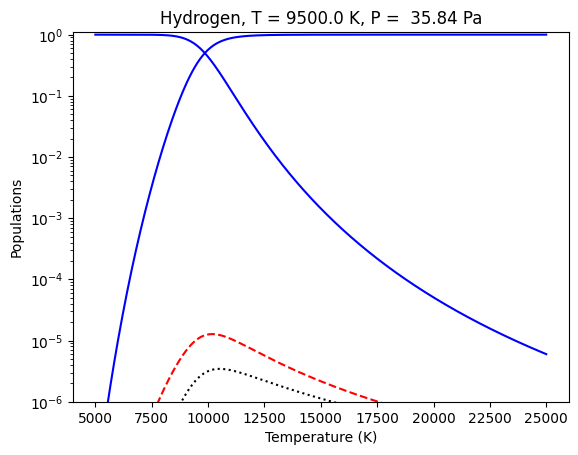

In [9]:
P_e = (N_e * constants.k_B * T).to('Pa')
temperatures = np.linspace(5000, 25000, 500) * units.K
h_atom.plot_payne(temperatures, P_e)
plt.title(f'Hydrogen, T = {T}, P = {P_e[0]: .2f}');

We are not asked about explaining the plot, but I can if that could give us more points? What do you think?

I think we should still give a short explanation. Compare with the effective temperature of the Sun where hydrogen is ionised?

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Exercise 3: Carbon [44 points]

Carbon is an element essential to life on Earth. It is the fourth most abundant element in the Universe (after hydrogen, helium, and oxygen), and in the colder regions of the Sun and solar system, it easily forms molecules, most commonly in the form of hydrocarbonates. In astrophysics, molecules such as CO can be used to trace star formation in distant galaxies, and carbon lines are important diagnostics of temperature in stars. For example, the ultraviolet C II lines with wavelengths of 133.4532 nm, 133.5663 nm, and 133.5708 nm can be used to detect if a star has a chromosphere (a hot layer around its surface). In the Sun, these lines are also routinely observed by NASA's [Interface Region Imaging Spectrograph](https://science.nasa.gov/mission/iris/) (IRIS) mission, where they are used to trace the dynamics and energetics of the solar chromosphere. 

The provided file `CI-III.txt` contains the energy levels of neutral and singly-ionised C, plus the ionisation energy of doubly-ionised C (C III). Use this file to answer this exercise.
    
* *[7 points]* In the CI-III.txt file, identify the level energies and statistical weights of the lower and upper levels of the C II lines at 133.4532 nm and 133.5663 nm. The 133.4532 nm line is a resonance line, and both lines share the same upper level. 
* *[8 points]* Assuming Saha-Boltzmann statistics and an electron pressure of 1 kPa, what is the range of temperatures where C is mostly in the singly ionised form? Compare with hydrogen and discuss.
* *[10 points]* Making use of the [NIST Atomic Spectra Database Levels form](https://physics.nist.gov/PhysRefData/ASD/levels_form.html), extend the C atom file to include all ionisation stages up to (and including) C VII. Make a modified "Payne plot" to show only the strength of the ionisation stages as function of temperature for this new model atom. Plot for an electron pressure of 1 kPa and a range of temperatures between $3500$ and $10^7$ K.
* *[9 points]* In diffuse media where densities are much lower, collisions are much less frequent and the Saha ionisation no longer applies. In these conditions, it is common to use the *Collisional Ionisation Equilibrium* (CIE), also called *coronal equilibrium* since it is a good approximation for the coronae of stars. The provided file `C_CIE.txt` contains the ionisation fractions of carbon (up to C VII) as a function of temperature. Compare the ionisation fractions under CIE with the Saha (previous point) and discuss the differences. Which approximation is best on the surface of the Sun?
* *[10 points]* Under Collisional Ionisation Equilibrium, a bound-free transition can cool a gas, but the same is not true under Saha ionisation. Why is this? Discuss.



## Identifying the level energies and statistical weights:

In [113]:
c_atom = Atom('C_I-III.txt')
thr = 1e-4 * units.nm # threshold
wavelengths = [133.4532, 133.5663] * units.nm
wavelengths_c_II = c_atom.chi[1].to('nm', equivalencies = units.spectral()) # wavelengths for C II [nm]
indx_1 = np.where(np.abs(wavelengths_c_II - wavelengths[0]) <= thr)[0]
indx_2 = np.where(np.abs(wavelengths_c_II - wavelengths[1]) <= thr)[0]
print("indexes = ", indx_1, indx_2)
#print(wavelengths_c_II)
# I only get index for the first one. When printing all wavelengths it can be seen that none
# match the second wavelength...
# what is meant by upper and lower level??
level_E = c_atom.chi[1, indx_1]
print(level_E)
weights = c_atom.g[1, indx_1]
print(weights);

indexes =  [6] []
[1.48849541] aJ
[4.]


## Range of temperatures where C is mostly in singly ionized form;

(20000.0, 70000.0)

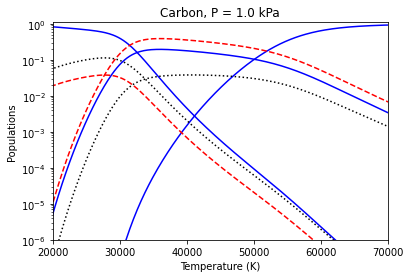

In [51]:
temperatures = np.linspace(5000, 100000, 500) * units.K
pressure = 1 * units.kPa
c_atom.plot_payne(temperatures, pressure)
plt.title(f'Carbon, P = {pressure}');
plt.xlim(20000, 70000) # zoom into area of interest

Assuming Saha-Boltzmann statistics and electron pressure of 1 kPa, we see that carbon is mostly singly ionised in the temperature range between 30000 K and 50000 K. We make a payne plot in the same temperature range for hydrogen to compare:

(5000.0, 25000.0)

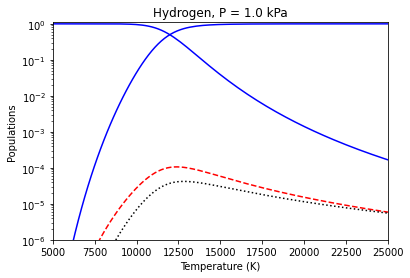

In [57]:
temperatures = np.linspace(5000, 100000, 500) * units.K
pressure = 1 * units.kPa
h_atom.plot_payne(temperatures, pressure)
plt.title(f'Hydrogen, P = {pressure}');
plt.xlim(5000, 25000) # zoom into area of interest

Since hydrogen only has one electron it can only be singly ionised. We see from the plot above that most of the hydrogen is singly ionized after about 13 000 K. This is at a much lower temperature than for carbon. MORE PHYSICAL MEANING? We can also compare this hydrogen plot to the one shown in exercise 2. We see that when we increase the pressure, as we did in this exercise, the curves seem to shift to the right and we need a higher temperature to ionize the atom.

## Strength of ionization stages as function of temperature:

We assume that the ionization stage strength is the population sum over all levels in the given stages.

"\nc_atom_extended.plot_payne(temperatures, pressure)\nplt.xlim(0, 0.6*1e6) \nplt.title(f'Carbon, T = [3500 - $10^7$] K, P = {pressure}');"

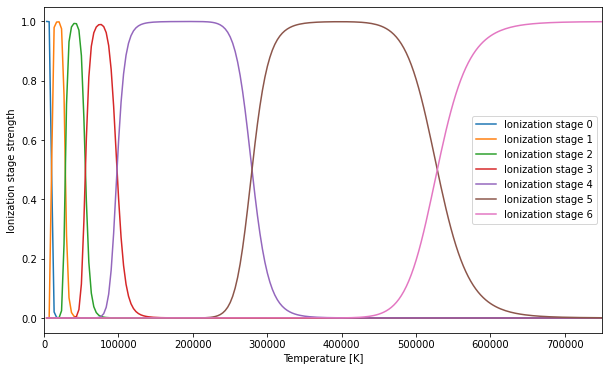

In [97]:
c_atom_extended = Atom('C_I-VII.txt')
temperatures = np.linspace(3500, 1e7, 3000) * units.K
pressure = 1 * units.kPa
pops = c_atom_extended.compute_populations(temperatures, pressure) # shape (7, 401, 1000)
total_populations = np.nansum(pops, axis=1)

plt.figure(figsize=(10,6))
for i in range(7):
    plt.plot(temperatures, total_populations[i, :], label=f"Ionization stage {i}")

plt.legend()
plt.title("")
plt.xlabel('Temperature [K]')
plt.ylabel('Ionization stage strength')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 0.75e6)

"""
c_atom_extended.plot_payne(temperatures, pressure)
plt.xlim(0, 0.6*1e6) 
plt.title(f'Carbon, T = [3500 - $10^7$] K, P = {pressure}');"""

## Comparison of the ionisation fractions under CIE with the Saha

(0.0, 2000000.0)

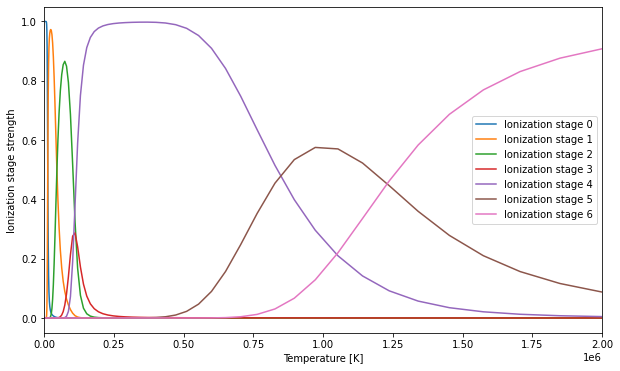

In [111]:
# Retrieving data from C_CIE.txt-file:
data = np.loadtxt("C_CIE.txt", skiprows=2)
temp = data[:, 0]
strength = data[:, 1:]

plt.figure(figsize=(10,6))
for i in range(7):
    plt.plot(temp, strength[:, i], label=f"Ionization stage {i}")

plt.legend()
plt.title("")
plt.xlabel('Temperature [K]')
plt.ylabel('Ionization stage strength')
plt.xlim(0, 2e6)

Under Collisional Ionisation Equilibrium, a bound-free transition can cool a gas, but the same is not true under Saha ionisation. Why is this? Discuss